# Multiclass Classification

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/mbarbetti/lymphoma-classification/blob/master/4_multi_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/mbarbetti/lymphoma-classification/blob/master/4_multi_classification.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection  import StratifiedShuffleSplit
from sklearn.preprocessing    import MinMaxScaler
from imblearn.over_sampling   import SMOTE
from sklearn.dummy            import DummyClassifier
from sklearn.linear_model     import LogisticRegression
from sklearn.svm              import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble         import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics          import confusion_matrix, roc_auc_score, roc_curve

from utils import custom_predictions, plot_clf_region, multiclass_promo, plot_conf_matrices

LABELS = ["cHL", "GZL", "PMBCL"]

## Data loading and preparation

In [2]:
data_dir  = "./data"
data_file = "db_mediastinalbulky_reduced.pkl" 
file_path = os.path.join ( data_dir, data_file )

with open (file_path, "rb") as file:
  data = pickle.load (file)

data.query("lymphoma_type == 2") . info()   # Gray-zone instances

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 81 to 89
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   ID                                    9 non-null      float64
 1   lymphoma_type                         9 non-null      float64
 2   CONVENTIONAL_SUVbwmidpoint            9 non-null      float64
 3   CONVENTIONAL_SUVbwmean                9 non-null      float64
 4   CONVENTIONAL_TLG(mL)[onlyForPETorNM]  9 non-null      float64
 5   CONVENTIONAL_SUVbwSkewness            9 non-null      float64
 6   CONVENTIONAL_SUVbwKurtosis            9 non-null      float64
 7   GLCM_Homogeneity[=InverseDifference]  9 non-null      float64
 8   GLCM_Entropy_log10                    9 non-null      float64
 9   GLRLM_SRE                             9 non-null      float64
 10  GLRLM_LRE                             9 non-null      float64
 11  GLZLM_LGZE           

### Input/output preparation

In [3]:
cols = list ( data.columns )
X_cols = cols[2:]
y_cols = "lymphoma_type"

X  = data.query("lymphoma_type != 2")[X_cols] . to_numpy()
y  = data.query("lymphoma_type != 2")[y_cols] . to_numpy() . flatten()
y  = ( y == 3 )   # PMBCL/cHL classification

ratio_0 = len(y[y == True]) / len(y[y == False])
print ( "PMBCL-cHL ratio on data-set : {:.1f}%" . format (100 * ratio_0) )

PMBCL-cHL ratio on data-set : 35.8%


In [4]:
X_gz = data.query("lymphoma_type == 2")[X_cols] . to_numpy()
y_gz = data.query("lymphoma_type == 2")[y_cols] . to_numpy() . flatten()

ratio_1 = len(y_gz) / len(y[y == True])
print ( "GZL-PMBCL ratio on data-set : {:.1f}%" . format (100 * ratio_1) )

ratio_2 = len(y_gz) / len(y[y == False])
print ( "GZL-cHL ratio on data-set : {:.1f}%" . format (100 * ratio_2) )

GZL-PMBCL ratio on data-set : 31.0%
GZL-cHL ratio on data-set : 11.1%


### Train-set and test-set splitting

In [5]:
sss = StratifiedShuffleSplit ( n_splits = 1, test_size = 0.3 )
for idx_train, idx_test in sss . split ( X, y ):
  X_train , y_train = X[idx_train] , y[idx_train]
  X_test  , y_test  = X[idx_test]  , y[idx_test] 

In [6]:
## Train-set expansion
X_train_comb = np.concatenate ( [ X_train, X_gz ] )
y_train_comb = np.concatenate ( [ np.where(y_train, 3, 1), y_gz ] )

## Test-set expansion
X_test_comb = np.concatenate ( [ X_test, X_gz ] )
y_test_comb = np.concatenate ( [ np.where(y_test, 3, 1), y_gz ] )

### Data preprocessing

In [7]:
scaler = MinMaxScaler()

X_train_original = X_train

X_train = scaler . fit_transform ( X_train )
X_test  = scaler . transform ( X_test )

print ( f"Resulting mean on train-set : {np.mean(X_train, axis = 0)}" )
print ( f"Resulting mean on test-set  : {np.mean(X_test, axis = 0)}" )

Resulting mean on train-set : [0.44977613 0.32553922 0.17997134 0.43628627 0.2819499  0.38580515
 0.59162281 0.64765308 0.32120268 0.37210382 0.24777485]
Resulting mean on test-set  : [0.43014282 0.30533243 0.14719345 0.4991153  0.47620377 0.44168061
 0.55500521 0.57017682 0.41437244 0.45015376 0.22787013]


In [8]:
sm = SMOTE()   # oversampling technique
X_train_res, y_train_res = sm.fit_resample ( X_train , y_train )

In [9]:
X_gz = scaler . transform ( X_gz  )
X_train_comb = scaler . transform ( X_train_comb )
X_test_comb  = scaler . transform ( X_test_comb  )

In [10]:
print ( np.mean (X_gz, axis = 0) )
print ( np.mean (X_train_comb, axis = 0) )
print ( np.mean (X_test_comb, axis = 0) )

[0.57822757 0.39758114 0.27251684 0.41692784 0.23812007 0.29628566
 0.68342075 0.75031095 0.21402799 0.29004329 0.31086643]
[0.46321872 0.33307849 0.18965633 0.43426039 0.27736306 0.37643683
 0.60122957 0.65839635 0.30998672 0.36351609 0.25437746]
[0.46187527 0.32510001 0.17404846 0.4815037  0.42518583 0.41052455
 0.58252282 0.60877699 0.37144149 0.41584437 0.24565505]


## Dummy classifier

In [11]:
clf_dummy = DummyClassifier (strategy = "stratified")
clf_dummy . fit ( X_train_comb, y_train_comb )   # training over resampled train-set

y_pred_train_dummy = clf_dummy . predict ( X_train_comb )

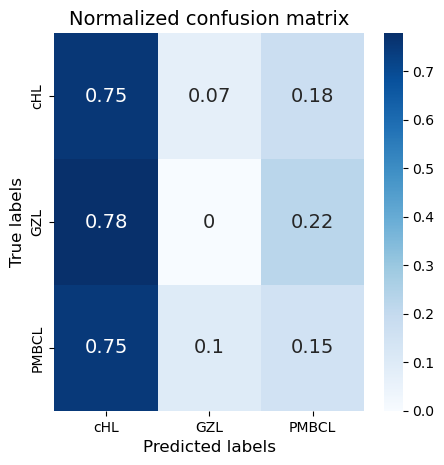

In [12]:
conf_matrix_train = confusion_matrix ( y_train_comb, y_pred_train_dummy )

plot_conf_matrices ( conf_matrix = conf_matrix_train, labels = LABELS, show_matrix = "norm", save_figure = False )

## Logistic regression

In [13]:
clf_logreg = LogisticRegression()
clf_logreg . fit ( X_train_res, y_train_res )

logreg_scores_train = clf_logreg . predict_proba ( X_train )
y_pred_train_logreg, th_logreg = custom_predictions ( y_true   = y_train , 
                                                      y_scores = logreg_scores_train , 
                                                      recall_score    = 0.8  , 
                                                      precision_score = None ,
                                                      show_curves = False , 
                                                      save_figure = False )

logreg_scores_gz = clf_logreg . predict_proba (X_gz)
y_pred_train_gz  = ( logreg_scores_gz[:,1] > th_logreg )

len(np.nonzero(y_pred_train_gz)[0]) / len(X_gz)   # GZL = uncertainty btw {cHL, PMBCL} 

0.6666666666666666

In [14]:
logreg_scores_train_comb = np.concatenate ( [ logreg_scores_train, logreg_scores_gz ] )

logreg_scores_test = clf_logreg . predict_proba ( X_test )
logreg_scores_test_comb  = np.concatenate ( [ logreg_scores_test , logreg_scores_gz ] )

In [15]:
def get_boundaries ( scores : np.ndarray , threshold : float , limits : float = 0.5 ):
  """Returns the custom boundaries for GZL predictions."""
  hist, bound = np.histogram ( scores[:,1], bins = 20 )
  cumsum  = np.cumsum ( hist.astype(np.float32) )
  cumsum /= cumsum[-1]

  x = ( bound[1:] + bound[:-1] ) / 2   # bin centers
  y = np.interp ( threshold, x, cumsum )   # cumulative value of custom threshold

  y_min = y - limits
  x_min = np.interp (y_min, cumsum, x)

  y_max = y + limits
  x_max = np.interp (y_max, cumsum, x)

  return x_min, x_max

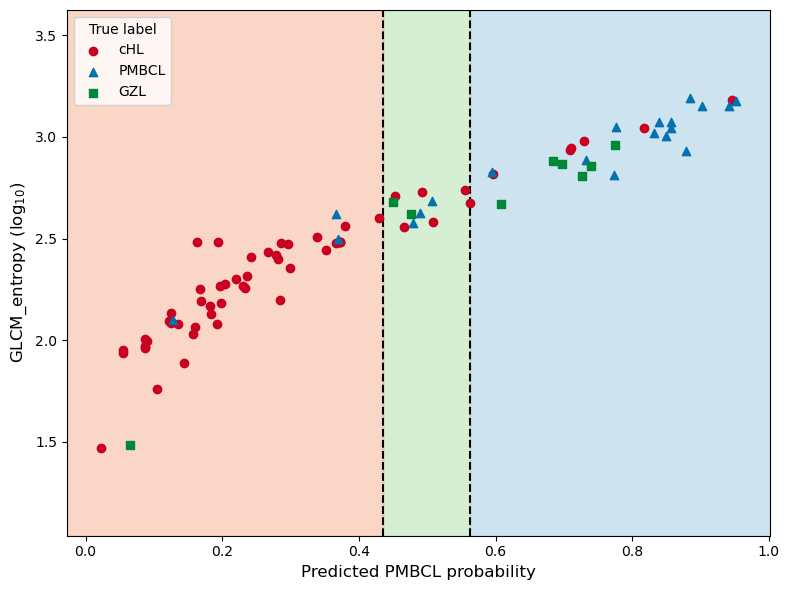

In [16]:
plot_clf_region ( y_true   = y_train_comb , 
                  y_scores = logreg_scores_train_comb ,
                  X_feat    = scaler . inverse_transform (X_train_comb) [:,6] ,
                  feat_name = "GLCM_entropy ($\log_{10}$)" ,
                  boundary  = get_boundaries ( logreg_scores_train, th_logreg, 0.5*len(y_gz)/len(y_train_comb) ) , 
                  labels = LABELS , 
                  save_figure = False )

#### Performance on train-set

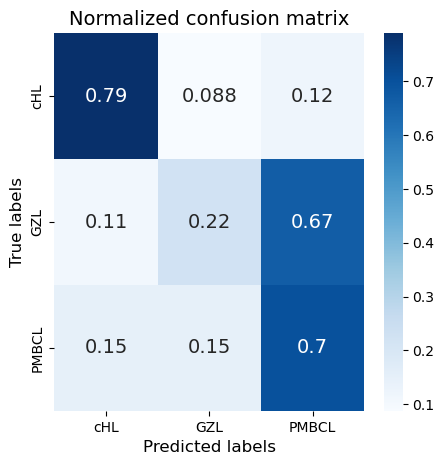

In [17]:
conf_matrix = multiclass_promo ( y_true = y_train_comb , 
                                 y_scores = logreg_scores_train_comb , 
                                 boundaries = get_boundaries (logreg_scores_train, th_logreg, 0.5*len(y_gz)/len(y_train_comb)) )

plot_conf_matrices ( conf_matrix = conf_matrix, labels = LABELS, show_matrix = "norm", save_figure = False )

#### Performance on test-set

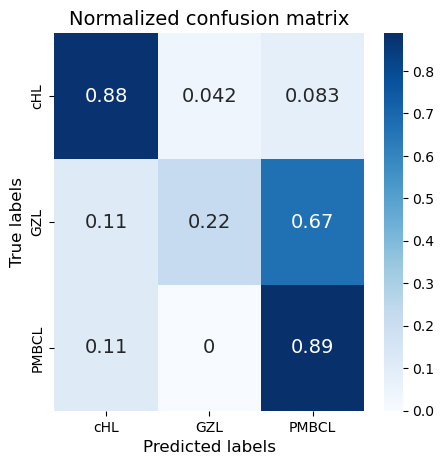

In [18]:
conf_matrix = multiclass_promo ( y_true = y_test_comb , 
                                 y_scores = logreg_scores_test_comb , 
                                 boundaries = get_boundaries (logreg_scores_train, th_logreg, 0.5*len(y_gz)/len(y_train_comb)) )

plot_conf_matrices ( conf_matrix = conf_matrix, labels = LABELS, show_matrix = "norm", save_figure = False )

## Linear SVM

In [19]:
clf_linsvm = SVC ( kernel = "linear", probability = True )
clf_linsvm . fit ( X_train_res, y_train_res )

linsvm_scores_train = clf_linsvm . predict_proba ( X_train )
y_pred_train_linsvm, th_linsvm = custom_predictions ( y_true   = y_train , 
                                                      y_scores = linsvm_scores_train , 
                                                      recall_score    = 0.8  , 
                                                      precision_score = None ,
                                                      show_curves = False , 
                                                      save_figure = False )

linsvm_scores_gz = clf_linsvm . predict_proba (X_gz)
y_pred_train_gz  = ( linsvm_scores_gz[:,1] > th_linsvm )

len(np.nonzero(y_pred_train_gz)[0]) / len(X_gz)   # GZL = uncertainty btw {cHL, PMBCL} 

0.6666666666666666

In [20]:
linsvm_scores_train_comb = np.concatenate ( [ linsvm_scores_train, linsvm_scores_gz ] )

linsvm_scores_test = clf_linsvm . predict_proba ( X_test )
linsvm_scores_test_comb  = np.concatenate ( [ linsvm_scores_test , linsvm_scores_gz ] )

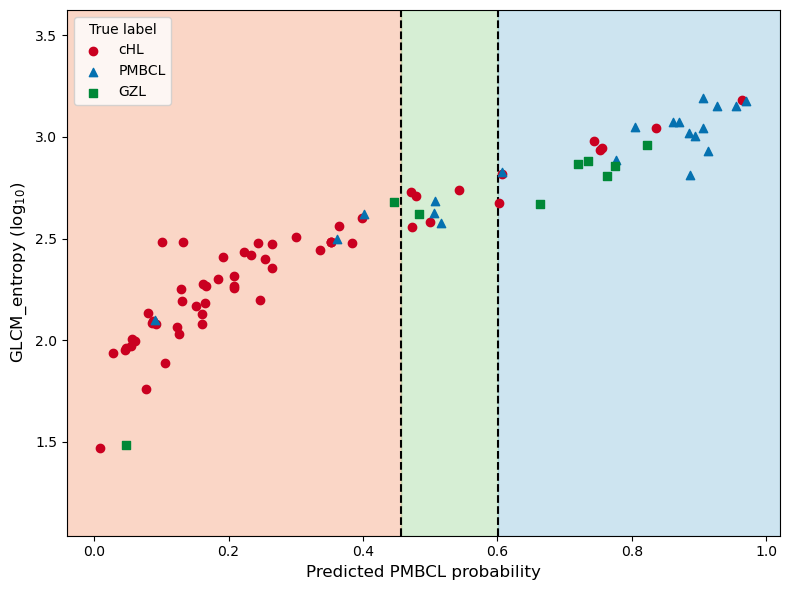

In [21]:
plot_clf_region ( y_true   = y_train_comb , 
                  y_scores = linsvm_scores_train_comb ,
                  X_feat    = scaler . inverse_transform (X_train_comb) [:,6] ,
                  feat_name = "GLCM_entropy ($\log_{10}$)" ,
                  boundary  = get_boundaries ( linsvm_scores_train, th_linsvm, 0.5*len(y_gz)/len(y_train_comb) ) , 
                  labels = LABELS , 
                  save_figure = False )

#### Performance on train-set

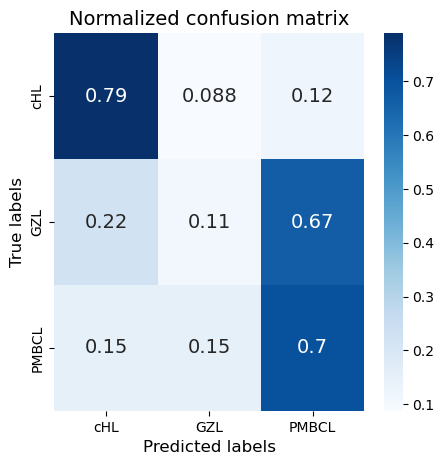

In [22]:
conf_matrix = multiclass_promo ( y_true = y_train_comb , 
                                 y_scores = linsvm_scores_train_comb , 
                                 boundaries = get_boundaries (linsvm_scores_train, th_linsvm, 0.5*len(y_gz)/len(y_train_comb)) )

plot_conf_matrices ( conf_matrix = conf_matrix, labels = LABELS, show_matrix = "norm", save_figure = False )

#### Performance on test-set

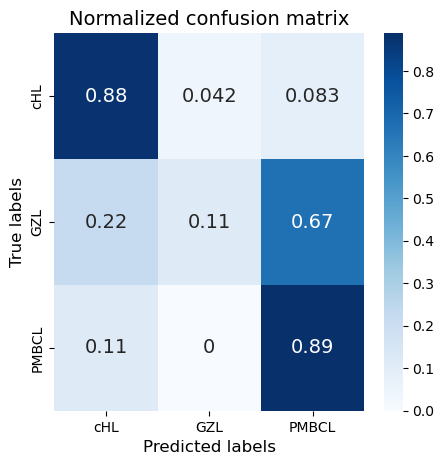

In [23]:
conf_matrix = multiclass_promo ( y_true = y_test_comb , 
                                 y_scores = linsvm_scores_test_comb , 
                                 boundaries = get_boundaries (linsvm_scores_train, th_linsvm, 0.5*len(y_gz)/len(y_train_comb)) )

plot_conf_matrices ( conf_matrix = conf_matrix, labels = LABELS, show_matrix = "norm", save_figure = False )

## Gaussian process

In [24]:
clf_gausproc = GaussianProcessClassifier()
clf_gausproc . fit ( X_train_res, y_train_res )

gausproc_scores_train = clf_gausproc . predict_proba ( X_train )
y_pred_train_gausproc, th_gausproc = custom_predictions ( y_true   = y_train , 
                                                          y_scores = gausproc_scores_train , 
                                                          recall_score    = 0.8  , 
                                                          precision_score = None ,
                                                          show_curves = False , 
                                                          save_figure = False )

gausproc_scores_gz = clf_gausproc . predict_proba (X_gz)
y_pred_train_gz  = ( gausproc_scores_gz[:,1] > th_gausproc )

len(np.nonzero(y_pred_train_gz)[0]) / len(X_gz)   # GZL = uncertainty btw {cHL, PMBCL} 

0.6666666666666666

In [25]:
gausproc_scores_train_comb = np.concatenate ( [ gausproc_scores_train, gausproc_scores_gz ] )

gausproc_scores_test = clf_gausproc . predict_proba ( X_test )
gausproc_scores_test_comb  = np.concatenate ( [ gausproc_scores_test , gausproc_scores_gz ] )

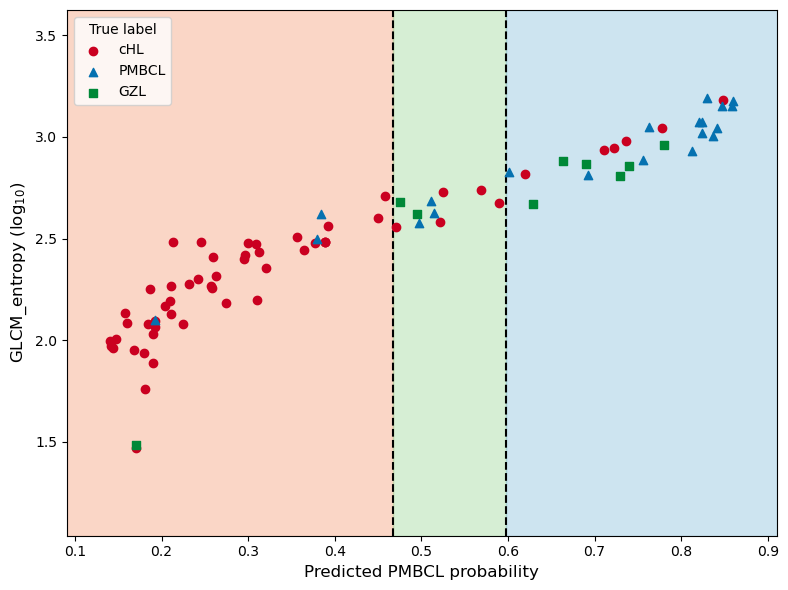

In [26]:
plot_clf_region ( y_true   = y_train_comb , 
                  y_scores = gausproc_scores_train_comb ,
                  X_feat    = scaler . inverse_transform (X_train_comb) [:,6] ,
                  feat_name = "GLCM_entropy ($\log_{10}$)" ,
                  boundary  = get_boundaries ( gausproc_scores_train, th_gausproc, 0.5*len(y_gz)/len(y_train_comb) ) , 
                  labels = LABELS , 
                  save_figure = False )

#### Performance on train-set

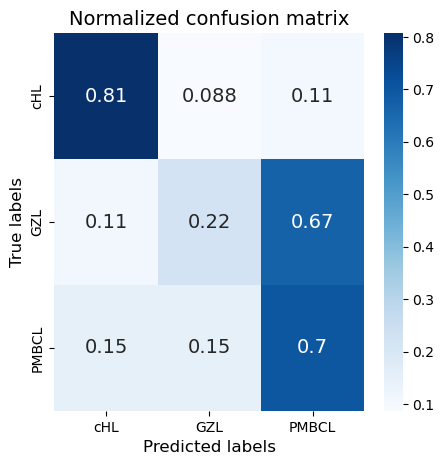

In [27]:
conf_matrix = multiclass_promo ( y_true = y_train_comb , 
                                 y_scores = gausproc_scores_train_comb , 
                                 boundaries = get_boundaries (gausproc_scores_train, th_gausproc, 0.5*len(y_gz)/len(y_train_comb)) )

plot_conf_matrices ( conf_matrix = conf_matrix, labels = LABELS, show_matrix = "norm", save_figure = False )

#### Performance on test-set

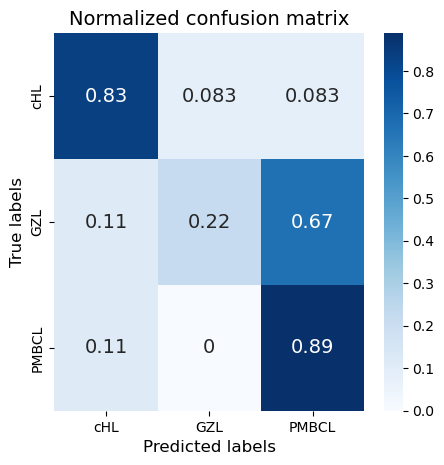

In [28]:
conf_matrix = multiclass_promo ( y_true = y_test_comb , 
                                 y_scores = gausproc_scores_test_comb , 
                                 boundaries = get_boundaries (gausproc_scores_train, th_gausproc, 0.5*len(y_gz)/len(y_train_comb)) )

plot_conf_matrices ( conf_matrix = conf_matrix, labels = LABELS, show_matrix = "norm", save_figure = False )

## Random forest

In [29]:
clf_rndfrs = RandomForestClassifier ( n_estimators = 100, max_depth = 1 )
clf_rndfrs . fit ( X_train_res, y_train_res )

rndfrs_scores_train = clf_rndfrs . predict_proba ( X_train )
y_pred_train_rndfrs, th_rndfrs = custom_predictions ( y_true   = y_train , 
                                                      y_scores = rndfrs_scores_train , 
                                                      recall_score    = 0.8  , 
                                                      precision_score = None ,
                                                      show_curves = False , 
                                                      save_figure = False )

rndfrs_scores_gz = clf_rndfrs . predict_proba (X_gz)
y_pred_train_gz  = ( rndfrs_scores_gz[:,1] > th_rndfrs )

len(np.nonzero(y_pred_train_gz)[0]) / len(X_gz)   # GZL = uncertainty btw {cHL, PMBCL} 

0.7777777777777778

In [30]:
rndfrs_scores_train_comb = np.concatenate ( [ rndfrs_scores_train, rndfrs_scores_gz ] )

rndfrs_scores_test = clf_rndfrs . predict_proba ( X_test )
rndfrs_scores_test_comb  = np.concatenate ( [ rndfrs_scores_test , rndfrs_scores_gz ] )

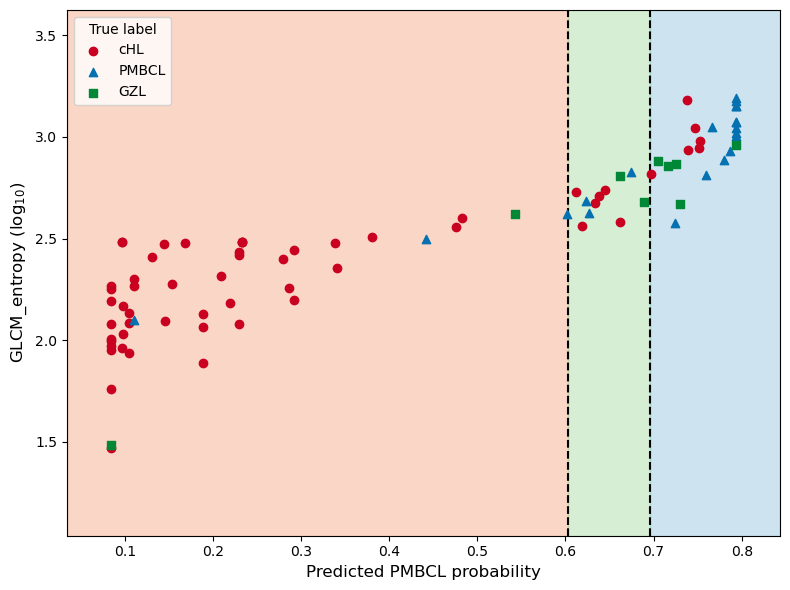

In [31]:
plot_clf_region ( y_true   = y_train_comb , 
                  y_scores = rndfrs_scores_train_comb ,
                  X_feat    = scaler . inverse_transform (X_train_comb) [:,6] ,
                  feat_name = "GLCM_entropy ($\log_{10}$)" ,
                  boundary  = get_boundaries ( rndfrs_scores_train, th_rndfrs, 0.5*len(y_gz)/len(y_train_comb) ) , 
                  labels = LABELS , 
                  save_figure = False )

#### Performance on train-set

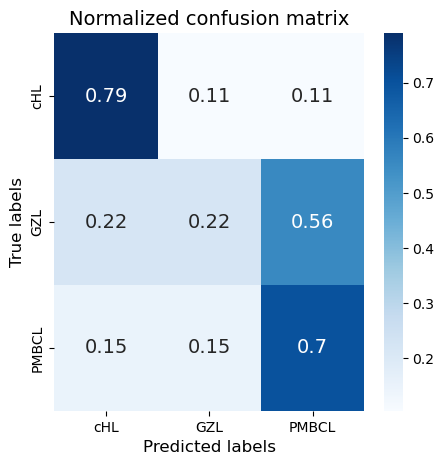

In [32]:
conf_matrix = multiclass_promo ( y_true = y_train_comb , 
                                 y_scores = rndfrs_scores_train_comb , 
                                 boundaries = get_boundaries (rndfrs_scores_train, th_rndfrs, 0.5*len(y_gz)/len(y_train_comb)) )

plot_conf_matrices ( conf_matrix = conf_matrix, labels = LABELS, show_matrix = "norm", save_figure = False )

#### Performance on test-set

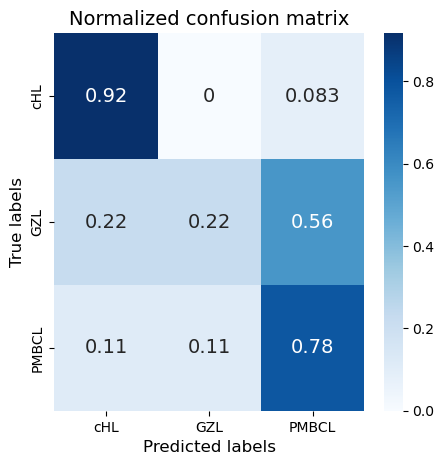

In [33]:
conf_matrix = multiclass_promo ( y_true = y_test_comb , 
                                 y_scores = rndfrs_scores_test_comb , 
                                 boundaries = get_boundaries (rndfrs_scores_train, th_rndfrs, 0.5*len(y_gz)/len(y_train_comb)) )

plot_conf_matrices ( conf_matrix = conf_matrix, labels = LABELS, show_matrix = "norm", save_figure = False )

## Gradient BDT

In [34]:
clf_gradbdt = GradientBoostingClassifier ( learning_rate = 0.2, n_estimators = 100, max_depth = 1 )
clf_gradbdt . fit ( X_train_res, y_train_res )

gradbdt_scores_train = clf_gradbdt . predict_proba ( X_train )
y_pred_train_gradbdt, th_gradbdt = custom_predictions ( y_true   = y_train , 
                                                        y_scores = gradbdt_scores_train , 
                                                        recall_score    = 0.8  , 
                                                        precision_score = None ,
                                                        show_curves = False , 
                                                        save_figure = False )

gradbdt_scores_gz = clf_gradbdt . predict_proba (X_gz)
y_pred_train_gz  = ( gradbdt_scores_gz[:,1] > th_gradbdt )

len(np.nonzero(y_pred_train_gz)[0]) / len(X_gz)   # GZL = uncertainty btw {cHL, PMBCL} 

0.1111111111111111

In [35]:
gradbdt_scores_train_comb = np.concatenate ( [ gradbdt_scores_train, gradbdt_scores_gz ] )

gradbdt_scores_test = clf_gradbdt . predict_proba ( X_test )
gradbdt_scores_test_comb  = np.concatenate ( [ gradbdt_scores_test , gradbdt_scores_gz ] )

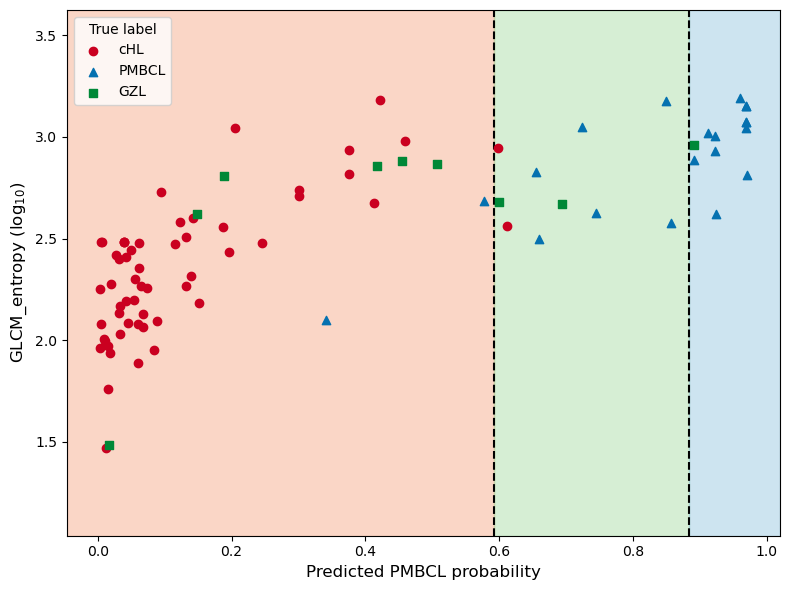

In [36]:
plot_clf_region ( y_true   = y_train_comb , 
                  y_scores = gradbdt_scores_train_comb ,
                  X_feat    = scaler . inverse_transform (X_train_comb) [:,6] ,
                  feat_name = "GLCM_entropy ($\log_{10}$)" ,
                  boundary  = get_boundaries ( gradbdt_scores_train, th_gradbdt, 0.5*len(y_gz)/len(y_train_comb) ) , 
                  labels = LABELS , 
                  save_figure = False )

#### Performance on train-set

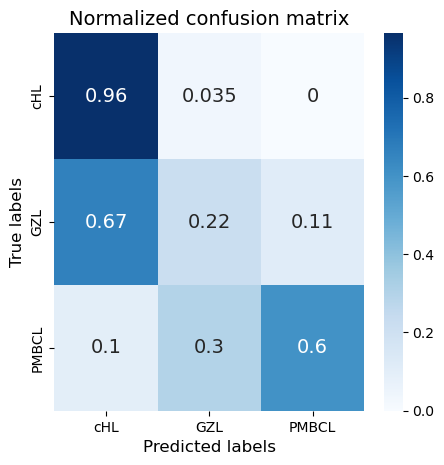

In [37]:
conf_matrix = multiclass_promo ( y_true = y_train_comb , 
                                 y_scores = gradbdt_scores_train_comb , 
                                 boundaries = get_boundaries (gradbdt_scores_train, th_gradbdt, 0.5*len(y_gz)/len(y_train_comb)) )

plot_conf_matrices ( conf_matrix = conf_matrix, labels = LABELS, show_matrix = "norm", save_figure = False )

#### Performance on test-set

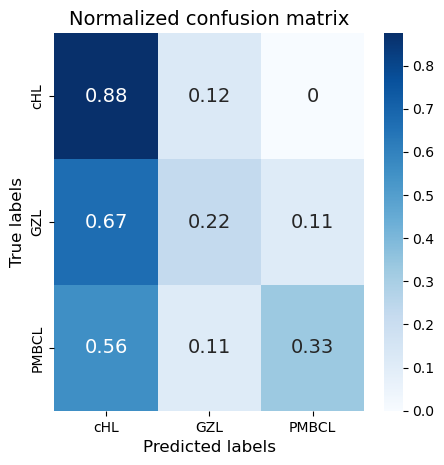

In [38]:
conf_matrix = multiclass_promo ( y_true = y_test_comb , 
                                 y_scores = gradbdt_scores_test_comb , 
                                 boundaries = get_boundaries (gradbdt_scores_train, th_gradbdt, 0.5*len(y_gz)/len(y_train_comb)) )

plot_conf_matrices ( conf_matrix = conf_matrix, labels = LABELS, show_matrix = "norm", save_figure = False )

## Models comparison

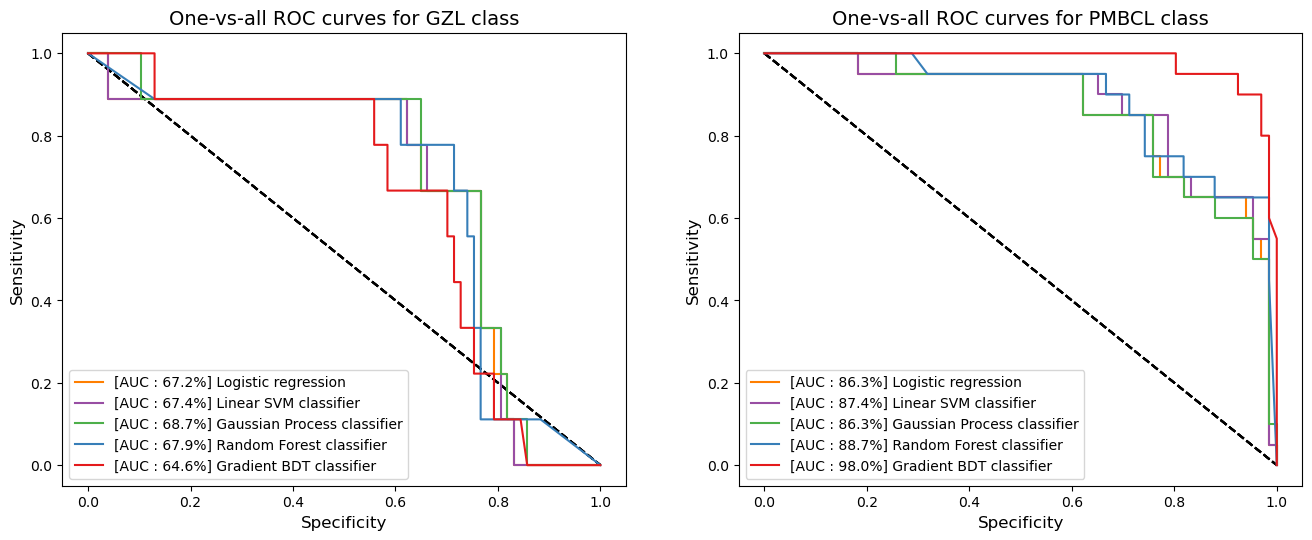

In [39]:
model_scores = [logreg_scores_train_comb[:,1], linsvm_scores_train_comb[:,1], gausproc_scores_train_comb[:,1], rndfrs_scores_train_comb[:,1], gradbdt_scores_train_comb[:,1]]
colors = ["#ff7f00", "#984ea3", "#4daf4a",  "#377eb8", "#e41a1c"]
styles = ["-", "-", "-", "-", "-"]
labels = ["Logistic regression", 
          "Linear SVM classifier", "Gaussian Process classifier", 
          "Random Forest classifier", "Gradient BDT classifier"]

fig, ax = plt.subplots (nrows = 1, ncols = 2, figsize = (16,6), dpi = 100)
for i in range(2):
  ax[i].set_xlabel ("Specificity", fontsize = 12)
  ax[i].set_ylabel ("Sensitivity", fontsize = 12)
  if (i == 0):
    ax[i].set_title ("One-vs-all ROC curves for GZL class", fontsize = 14)
    y_true = ( y_train_comb == 2 )
  else:
    ax[i].set_title ("One-vs-all ROC curves for PMBCL class", fontsize = 14)
    y_true = ( y_train_comb == 3 )
  for z, (score, col, stl, lbl) in enumerate ( zip (model_scores, colors, styles, labels) ):
    auc = roc_auc_score ( y_true, score )
    fpr, tpr, _ = roc_curve ( y_true, score )
    ax[i].plot ([0,1], [1,0], color = "black", linestyle = "--", zorder = 0)
    ax[i].plot (1 - fpr, tpr, color = col, linestyle = stl, label = f"[AUC : {100*auc:.1f}%] {lbl}", zorder = z)
  ax[i].legend (loc = "lower left", fontsize = 10)
plt.show()